In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

이 코드는 matplotlib와 seaborn을 사용하여 거래 금액의 분포를 시각화하는 함수입니다. 여러 개의 서브플롯을 생성하여 거래 금액의 분포와 사기 거래 여부에 따른 분포를 비교합니다.

In [3]:
df_id = pd.read_csv('train_identity.csv')
df_trans = pd.read_csv('train_transaction.csv')

test_id =pd.read_csv('test_identity.csv')
test_trans = pd.read_csv('test_transaction.csv')

In [4]:
train_merged = pd.merge(df_id,df_trans, on='TransactionID', how='inner')
test_merged = pd.merge(test_id, test_trans, on='TransactionID', how='inner')

In [5]:
# df_trans['TransactionAmt'].describe()
# df_trans[df_trans['TransactionAmt'] > 2000]['isFraud'].value_counts()[1]

In [6]:
# train_merged['isFraud'].isnull().sum()

In [7]:
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


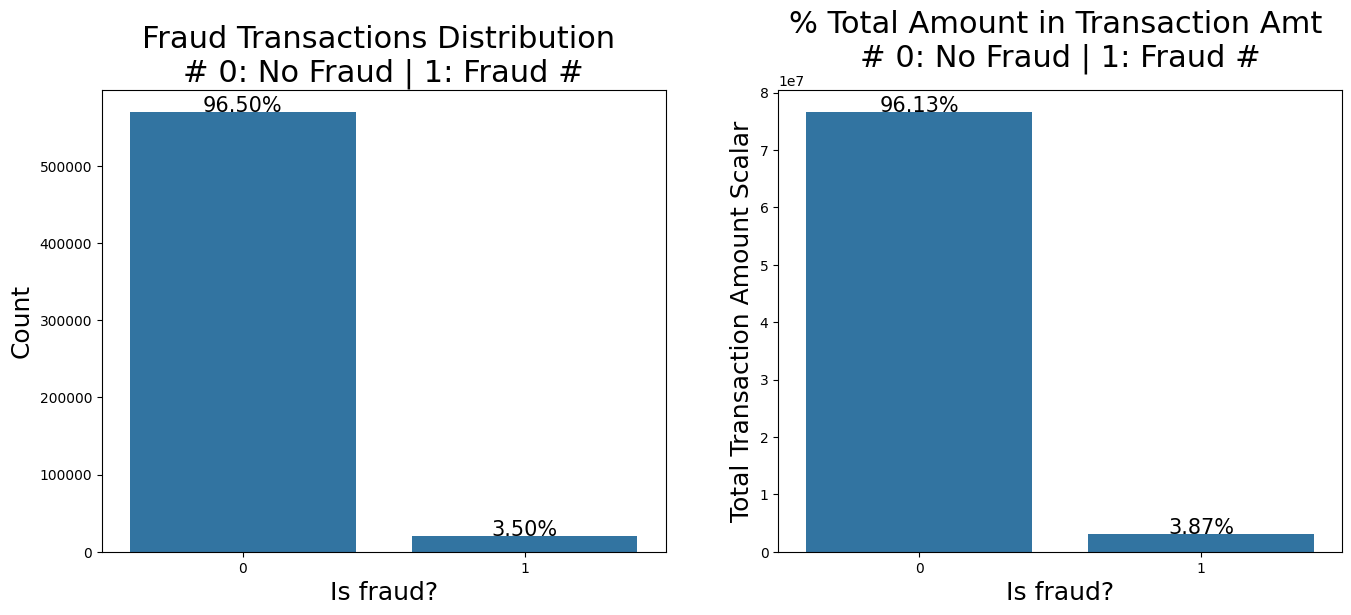

In [8]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    

In [9]:
# tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
# tmp = tmp.reset_index()
# tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

# plt.figure(figsize=(14,10))
# plt.suptitle('ProductCD Distributions', fontsize=22)

# plt.subplot(221)
# g = sns.countplot(x='ProductCD', data=df_trans)
# # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

# g.set_title("ProductCD Distribution", fontsize=19)
# g.set_xlabel("ProductCD Name", fontsize=17)
# g.set_ylabel("Count", fontsize=17)
# g.set_ylim(0,500000)
# for p in g.patches:
#     height = p.get_height()
#     g.text(p.get_x()+p.get_width()/2.,
#             height + 3,
#             '{:1.2f}%'.format(height/total*100),
#             ha="center", fontsize=14) 

# plt.subplot(222)
# g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
# plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
# gt = g1.twinx()
# gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
# gt.set_ylabel("% of Fraud Transactions", fontsize=16)

# g1.set_title("Product CD by Target(isFraud)", fontsize=19)
# g1.set_xlabel("ProductCD Name", fontsize=17)
# g1.set_ylabel("Count", fontsize=17)

# plt.subplot(212)
# g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
#               data=df_trans[df_trans['TransactionAmt'] <= 2000] )
# g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
# g3.set_xlabel("ProductCD Name", fontsize=17)
# g3.set_ylabel("Transaction Values", fontsize=17)

# plt.subplots_adjust(hspace = 0.6, top = 0.85)

# plt.show()

ProductCD 분포 그래프:

plt.subplot(221) 부분에서 ProductCD의 분포를 보여주는 막대 그래프를 그립니다. 각 ProductCD 값에 대한 거래 수를 표시합니다.
그래프 제목은 "ProductCD Distribution"이며, x축은 ProductCD 이름, y축은 거래 수를 나타냅니다.
ProductCD와 사기 여부에 따른 분포 그래프:

plt.subplot(222) 부분에서 ProductCD와 isFraud에 따른 분포를 보여주는 막대 그래프를 그립니다. 각 ProductCD 값에 대해 사기 거래와 비사기 거래의 수를 비교합니다.
그래프 제목은 "Product CD by Target(isFraud)"이며, x축은 ProductCD 이름, y축은 거래 수를 나타냅니다.
또한, ProductCD별 사기 거래 비율을 점 그래프로 표시합니다.
ProductCD와 거래 금액에 따른 분포 그래프:

plt.subplot(212) 부분에서 ProductCD와 isFraud에 따른 거래 금액 분포를 보여주는 박스 그래프를 그립니다. 거래 금액이 2000 이하인 데이터만 사용합니다.
그래프 제목은 "Transaction Amount Distribution by ProductCD and Target"이며, x축은 ProductCD 이름, y축은 거래 금액을 나타냅니다.
이 그래프들은 ProductCD와 사기 여부에 따른 거래 분포와 거래 금액의 차이를 시각적으로 분석하는 데 유용합니다.

In [10]:
# df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)

In [11]:
# ## Knowning the Card Features
# resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])


# Categorical_Card 4,6

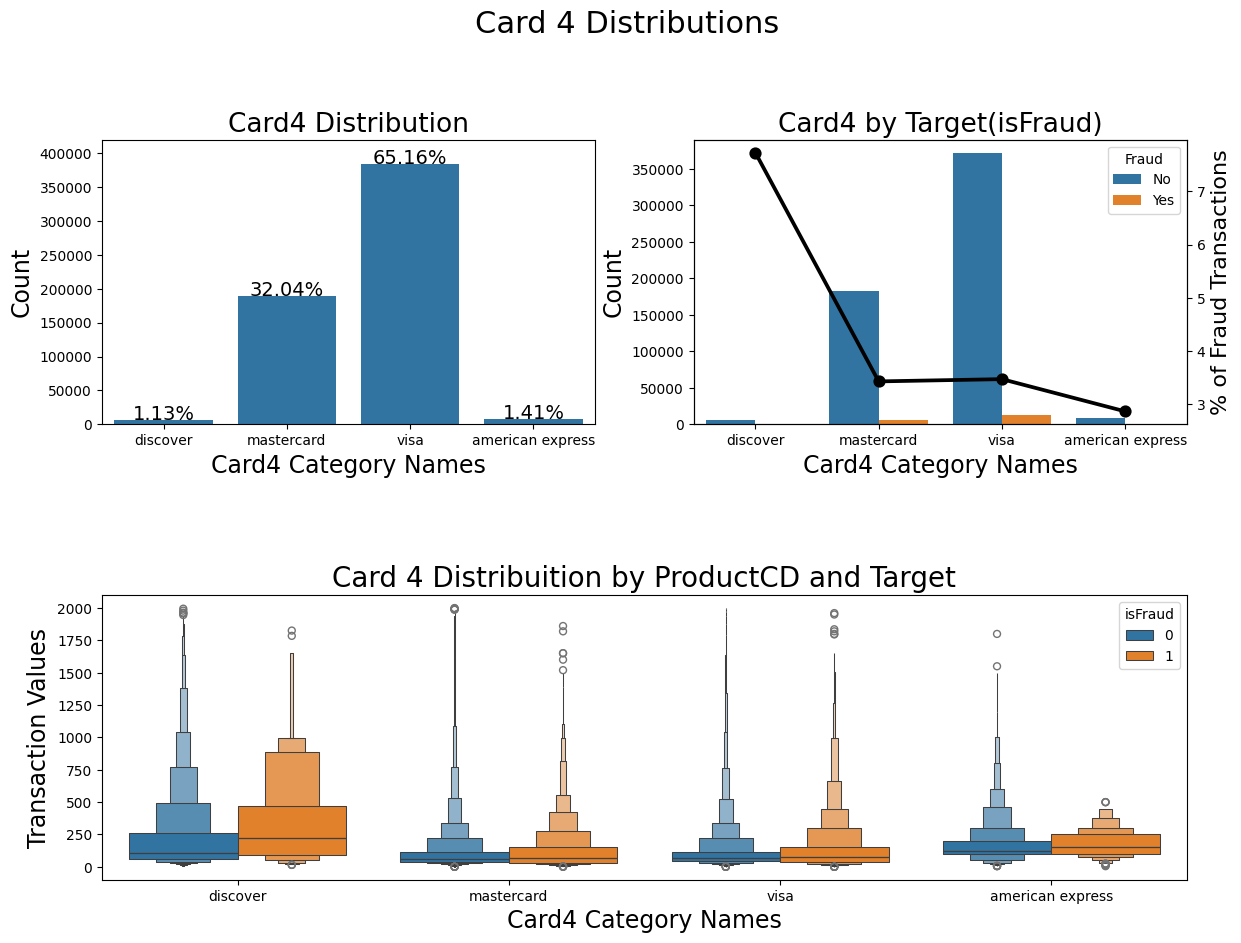

In [12]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

첫 번째 서브플롯 (221):
card4 변수의 분포를 보여주는 막대 그래프입니다.
각 card4 카테고리의 거래 수를 나타냅니다.
각 막대 위에 해당 카테고리의 거래 수를 백분율로 표시합니다.

두 번째 서브플롯 (222):
card4 변수와 isFraud 변수 간의 관계를 보여주는 막대 그래프입니다.
card4 카테고리별로 사기 거래와 정상 거래의 수를 비교합니다.
card4 카테고리별로 사기 거래의 비율을 점 그래프로 추가로 표시합니다.

세 번째 서브플롯 (212):
card4 변수와 TransactionAmt 변수 간의 관계를 보여주는 박스 그래프입니다.
TransactionAmt가 2000 이하인 거래만을 대상으로 합니다.
card4 카테고리별로 사기 거래와 정상 거래의 거래 금액 분포를 비교합니다.
이 모든 그래프는 card4 변수의 카테고리별로 거래 수와 거래 금액, 그리고 사기 거래 비율을 시각적으로 비교할 수 있도록 도와줍니다.

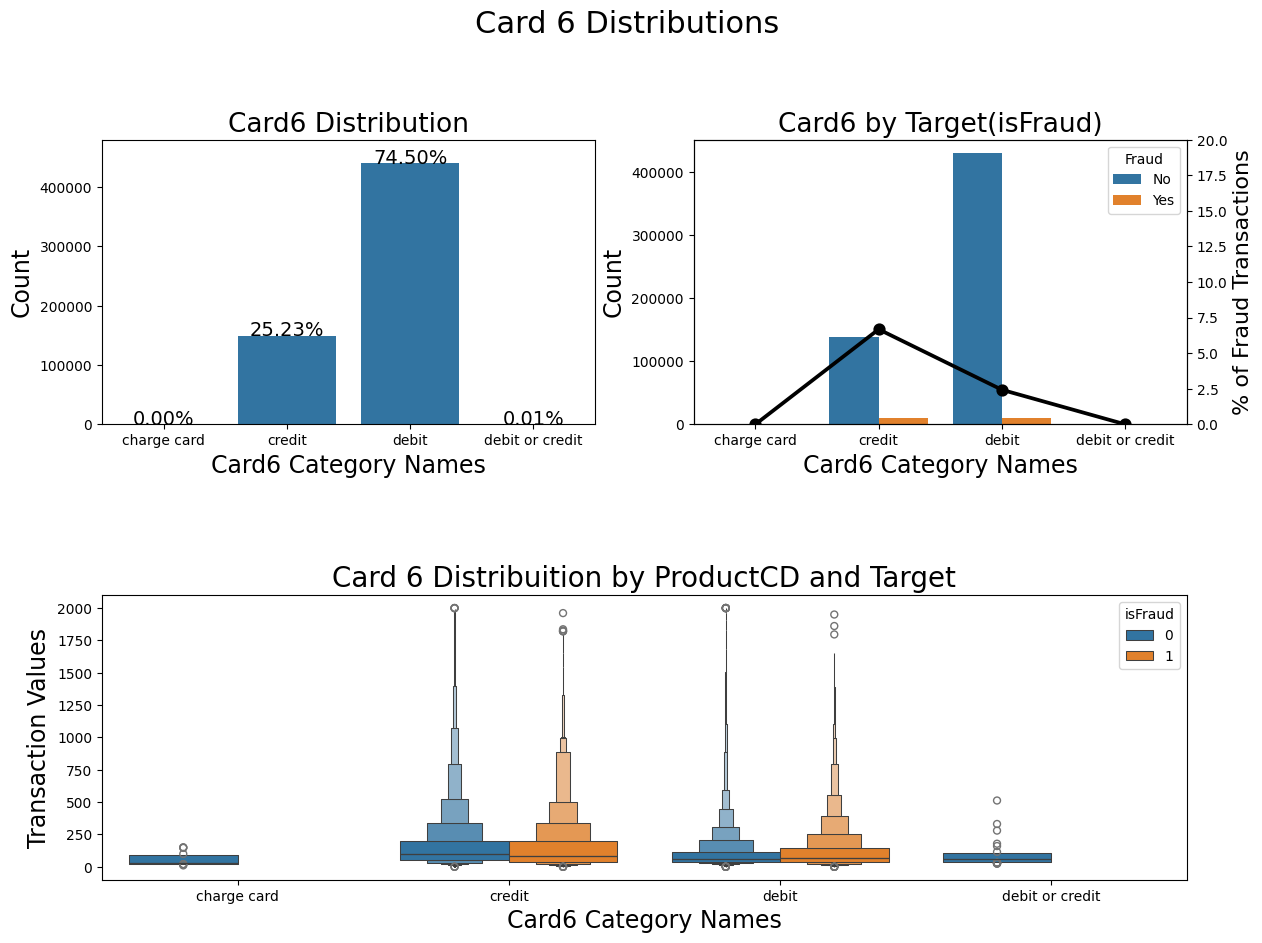

In [13]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

# DeviceType

In [14]:
df_id['DeviceType']

0          mobile
1          mobile
2         desktop
3         desktop
4         desktop
           ...   
144228     mobile
144229     mobile
144230     mobile
144231    desktop
144232     mobile
Name: DeviceType, Length: 144233, dtype: object

In [15]:
df_id['DeviceType'].unique()

array(['mobile', 'desktop', nan], dtype=object)

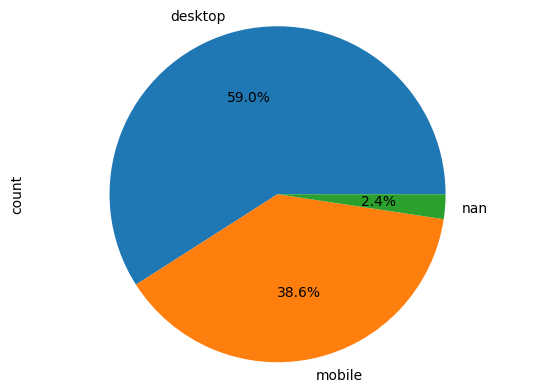

In [16]:
df_id['DeviceType'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

# DeviceInfo

In [17]:
df_id['DeviceInfo'].value_counts(dropna=False).head(10)

DeviceInfo
Windows                  47722
NaN                      25567
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
rv:57.0                    962
SM-J700M Build/MMB29K      549
SM-G610M Build/MMB29K      461
SM-G531H Build/LMY48B      410
Name: count, dtype: int64

In [18]:
df_id['DeviceInfo'].unique()

array(['SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'], dtype=object)

isFraud가 1인 값 (이상거래인 row)를 찾아서 DeviceType,DeviceInfo로 특정 디바이스에서 이상거래가 발생하는 지에 대한 예측을 하려 함

In [19]:
merged_Device = train_merged[['DeviceType', 'DeviceInfo', 'isFraud']]
merged_Device


,DeviceType,DeviceInfo,isFraud
0,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,mobile,iOS Device,0
2,desktop,Windows,0
3,desktop,NaN,0
4,desktop,MacOS,0
...,...,...,...
144228,mobile,F3111 Build/33.3.A.1.97,0
144229,mobile,A574BL Build/NMF26F,1
144230,mobile,Moto E (4) Plus Build/NMA26.42-152,0
144231,desktop,MacOS,0


In [20]:
fraud_rows = train_merged[train_merged['isFraud'] == 1]

In [21]:
fraud_rows

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
52,2987240,0.0,169947.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2987243,0.0,222455.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2987245,0.0,271870.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,2987288,-20.0,258138.0,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2987367,-5.0,141271.0,NaN,NaN,9.0,-81.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144202,3577351,-20.0,190267.0,NaN,NaN,-5.0,-20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144203,3577354,-25.0,229668.0,0.0,0.0,-5.0,-20.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144204,3577364,-5.0,183132.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144206,3577368,-5.0,214747.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
fraud_rows['isFraud'].value_counts()

isFraud
1    11318
Name: count, dtype: int64

모바일에서 더 높은 비율로 이상거래(사기거래)가 생기는 걸 확인

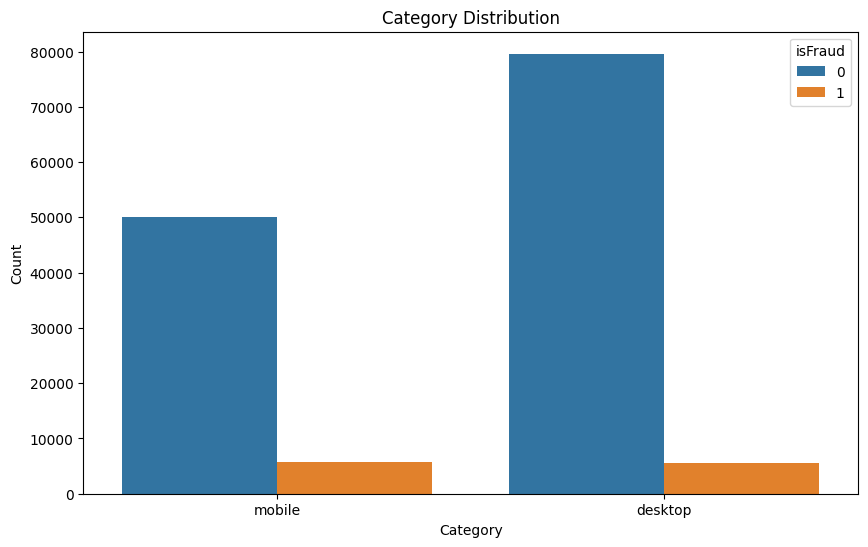

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_Device, x='DeviceType', hue='isFraud')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [51]:
def move_to_others(df, column, threshold):
    value_counts = df[column].value_counts()
    others = value_counts[value_counts < threshold].index
    df[column] = df[column].replace(others, 'others')
    return df
move_to_others(merged_Device, 'DeviceInfo', 600)

,DeviceType,DeviceInfo,isFraud
0,mobile,others,0
1,mobile,iOS Device,0
2,desktop,Windows,0
3,desktop,NaN,0
4,desktop,MacOS,0
...,...,...,...
144228,mobile,others,0
144229,mobile,others,1
144230,mobile,others,0
144231,desktop,MacOS,0


# id_cols

In [25]:
pd.set_option('display.max_columns', 100)

In [26]:
train_merged['id_01'].value_counts(dropna=False)

id_01
-5.0     82170
 0.0     19555
-10.0    11257
-20.0    11211
-15.0     5674
         ...  
-89.0        1
-93.0        1
-24.0        1
-94.0        1
-51.0        1
Name: count, Length: 77, dtype: int64

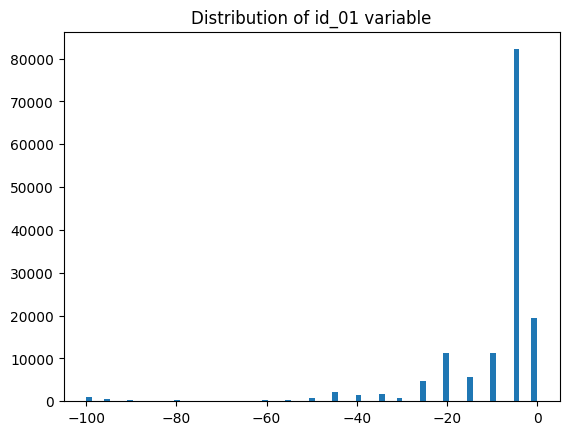

In [27]:
plt.hist(train_merged['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

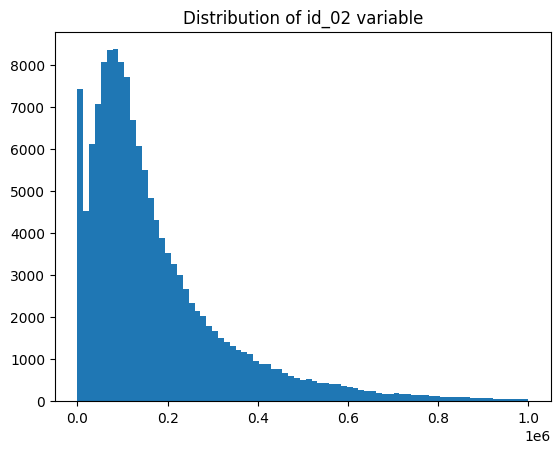

In [28]:
plt.hist(train_merged['id_02'], bins=77);
plt.title('Distribution of id_02 variable');

In [50]:
column_with_most_unique = df_id.loc[:, 'id_01':'id_38'].nunique().idxmax()
column_with_most_unique

'id_02'

In [29]:
train_merged['id_03'].value_counts(dropna=False, normalize=True).head()


id_03
NaN    0.540161
0.0    0.443054
1.0    0.005983
3.0    0.004631
2.0    0.002919
Name: proportion, dtype: float64

### id_02 = ip 주소일 가능성 다분
### id_03 = -10~10 숫자
### id_04 = -13~ 0 숫자
### id_05 =  -20~ 50 숫자
### id_06 = -100 대부분

In [52]:
df_id[['id_03', 'id_04', 'id_05', 'id_06']].describe()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning:

overflow encountered in cast

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning:

overflow encountered in cast

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning:

overflow encountered in cast

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

overflow encountered in reduce

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning:

overflow encountered in cast

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: Runti

,id_03,id_04,id_05,id_06
count,66324.0,66324.0,136865.0,136865.0
mean,0.0,-0.0,NaN,NaN
std,0.0,0.0,0.0,0.0
min,-13.0,-28.0,-72.0,-100.0
25%,0.0,0.0,0.0,-6.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,1.0,0.0
max,10.0,0.0,52.0,0.0


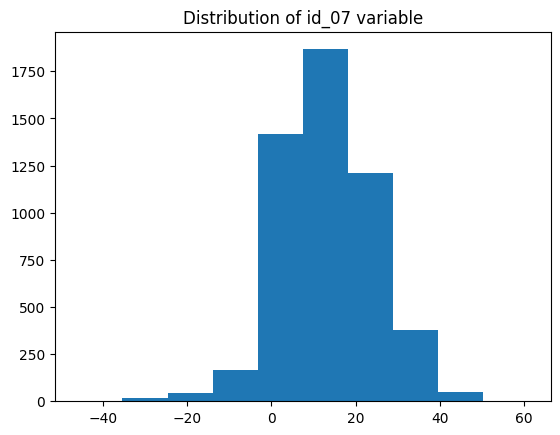

In [30]:
plt.hist(train_merged['id_07']);
plt.title('Distribution of id_07 variable');

In [31]:
train_merged['id_11'].value_counts(dropna=False, normalize=True).head()


id_11
100.000000    0.923242
NaN           0.022568
95.080002     0.008535
95.160004     0.005228
97.120003     0.003051
Name: proportion, dtype: float64

id_34확인


In [32]:
def extract_column_with_largest_unique_sum(df):
    id_columns = df.columns[df.columns.str.startswith('id_')]
    unique_sums = df[id_columns].nunique().sum()
    column_with_largest_unique_sum = df[id_columns].nunique().idxmax()
    return column_with_largest_unique_sum

In [33]:
def extract_non_null_with_isFraud(df, column_name):
    non_null_values = df[df[column_name].notnull()]
    is_fraud_values = non_null_values[non_null_values['isFraud'] == 1]
    return is_fraud_values

In [34]:
b = extract_non_null_with_isFraud(train_merged,'id_34')
b['id_34'].unique()

array(['match_status:2', 'match_status:1', 'match_status:0'], dtype=object)

In [35]:
train_merged[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.000000,80044.000000,140985,129340,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,5169,4747.000000,5132.000000,5163.000000,5169,140978,140978,77565,140282,77586.000000,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2,2,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,NaN,IP_PROXY:TRANSPARENT,NaN,NaN,NaN,Found,Found,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,NaN,3489,NaN,NaN,NaN,5155,76232,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,48.053071,-344.507146,NaN,NaN,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,NaN,12.800927,329.608924,149.070308,NaN,NaN,NaN,NaN,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,11.774858,93.695502,NaN,NaN,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,NaN,2.372447,97.461089,32.101995,NaN,NaN,NaN,NaN,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.000000,-660.000000,NaN,NaN,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,NaN,11.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.000000,-360.000000,NaN,NaN,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,NaN,11.000000,321.000000,119.000000,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.000000,-300.000000,NaN,NaN,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,NaN,11.000000,321.000000,149.000000,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.000000,-300.000000,NaN,NaN,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,NaN,15.000000,371.000000,169.000000,NaN,NaN,NaN,NaN,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN


이 함수는 데이터 분석 및 시각화 과정에서 범주형 변수와 사기 거래 간의 관계를 이해하는 데 유용합니다.



In [36]:
train_merged['id_12'].isnull().sum()

0

In [37]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

In [38]:
train_merged.loc[train_merged['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train_merged.loc[train_merged['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train_merged.loc[train_merged['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train_merged.loc[train_merged['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train_merged['id_30'].fillna("NAN", inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\3902035073.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





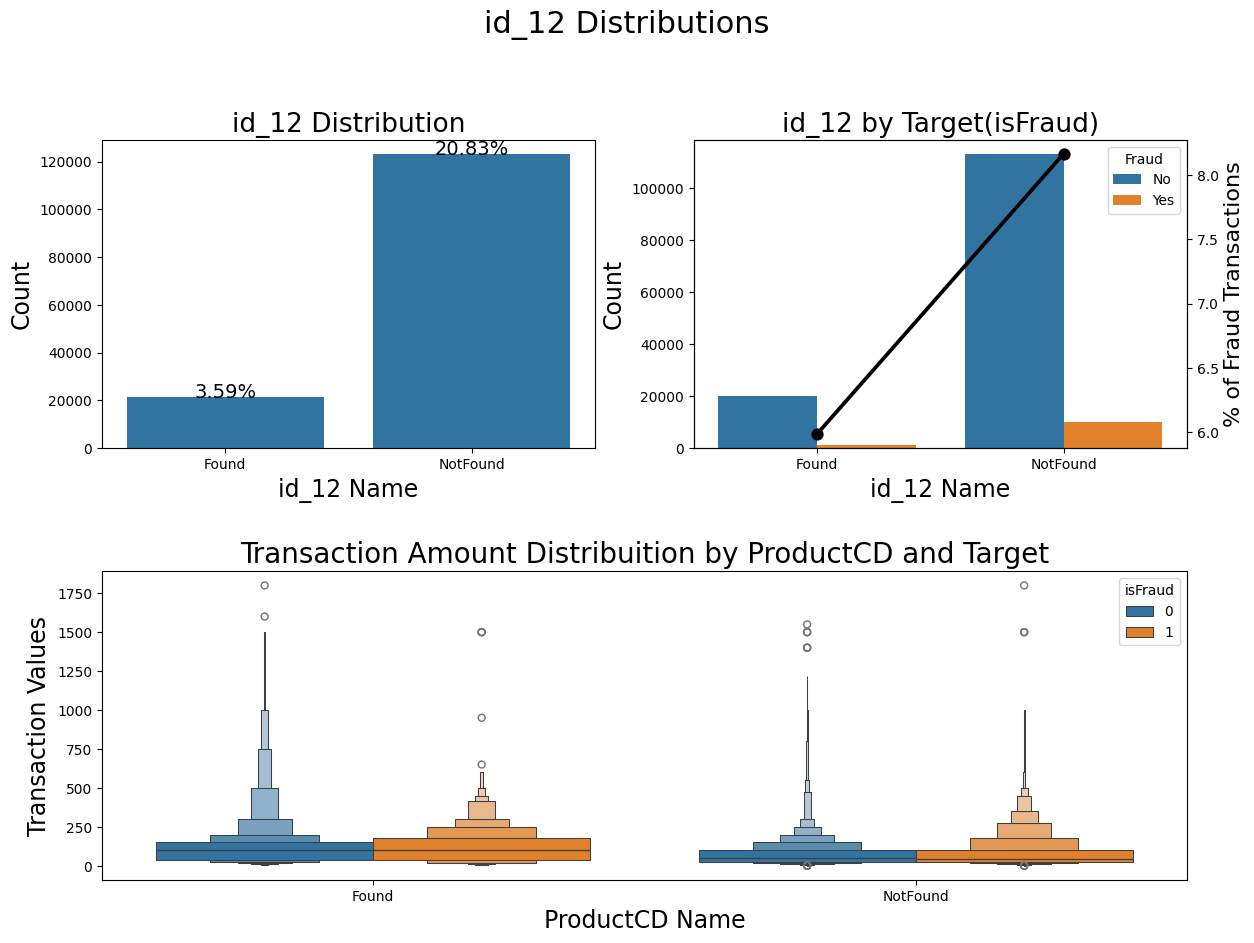

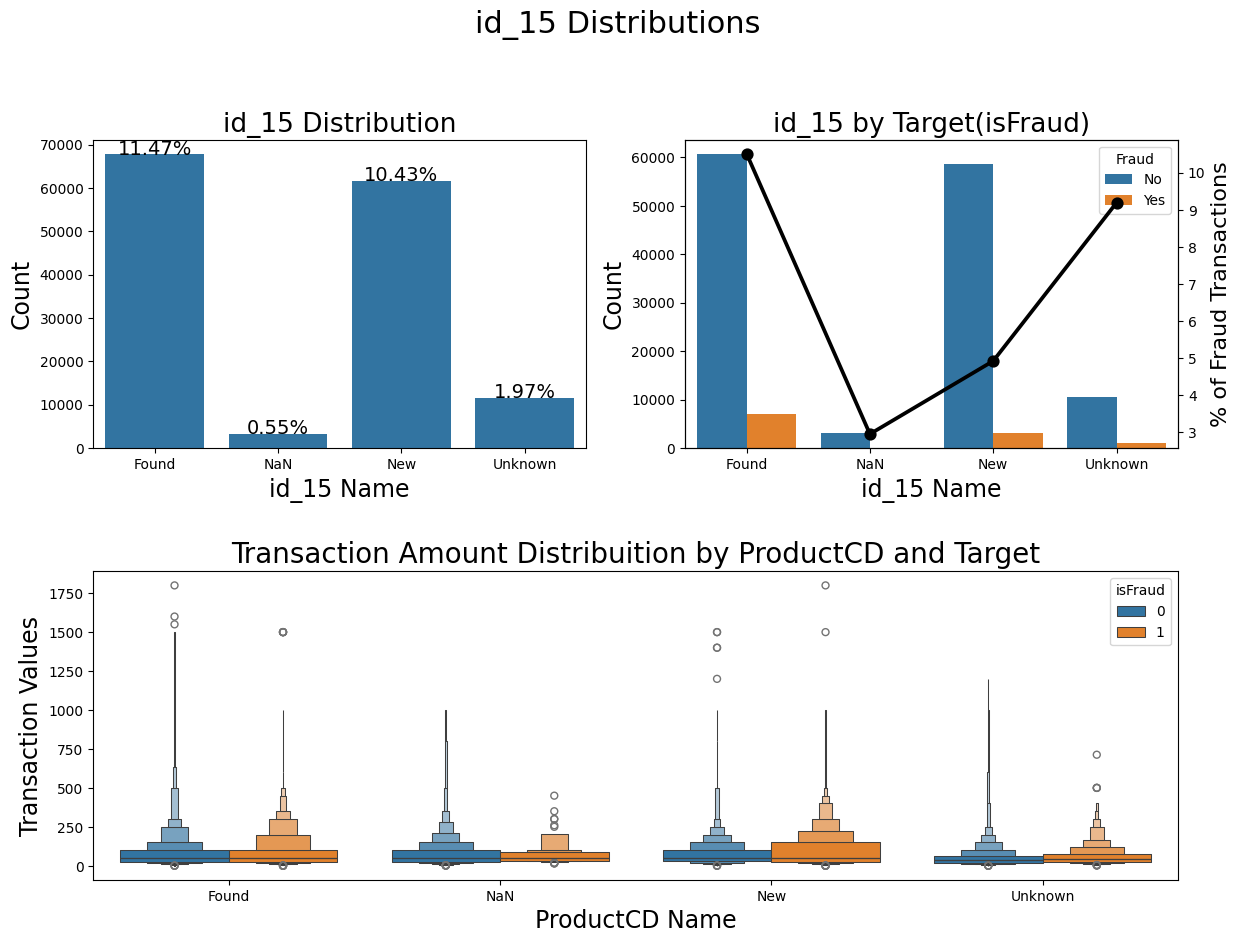

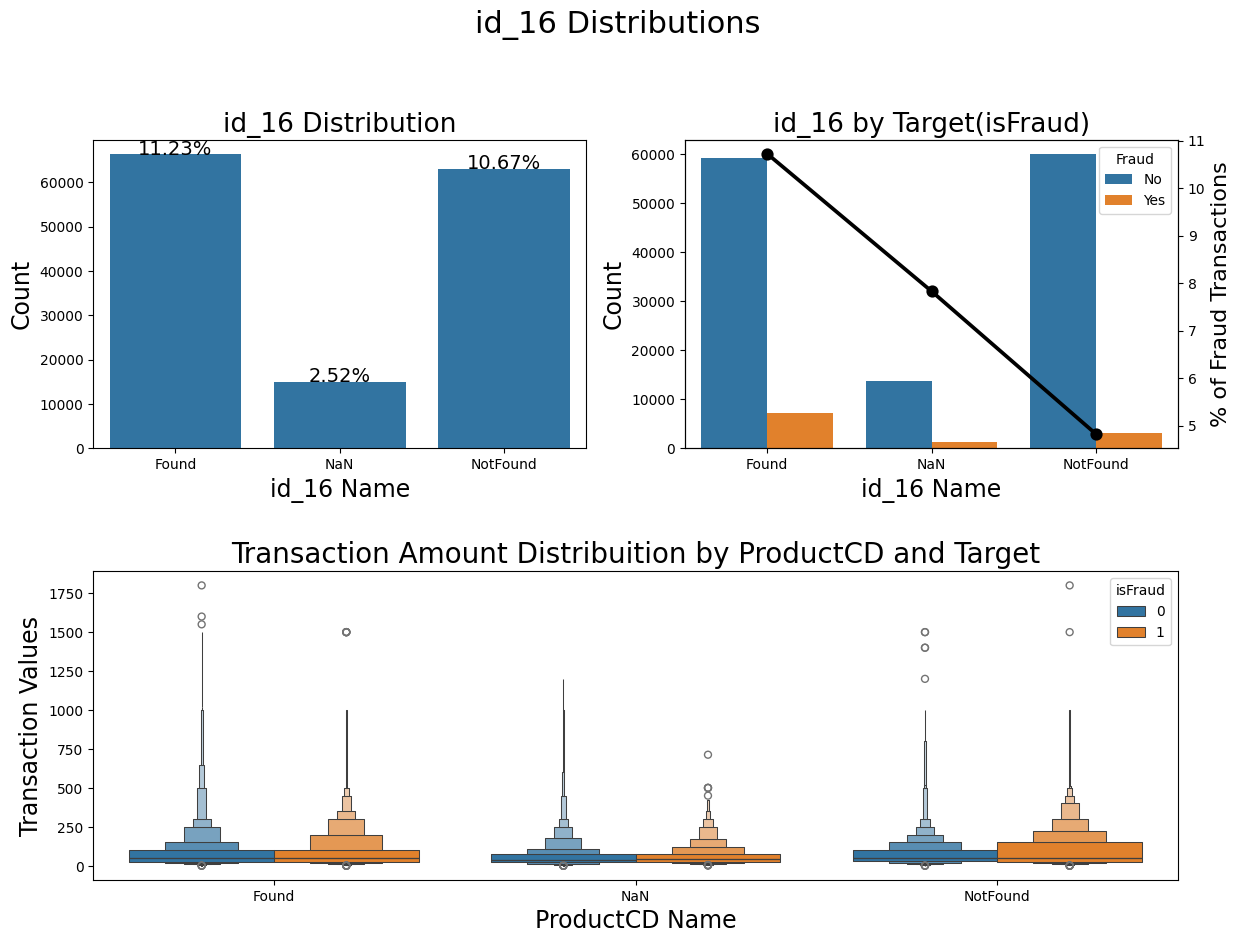

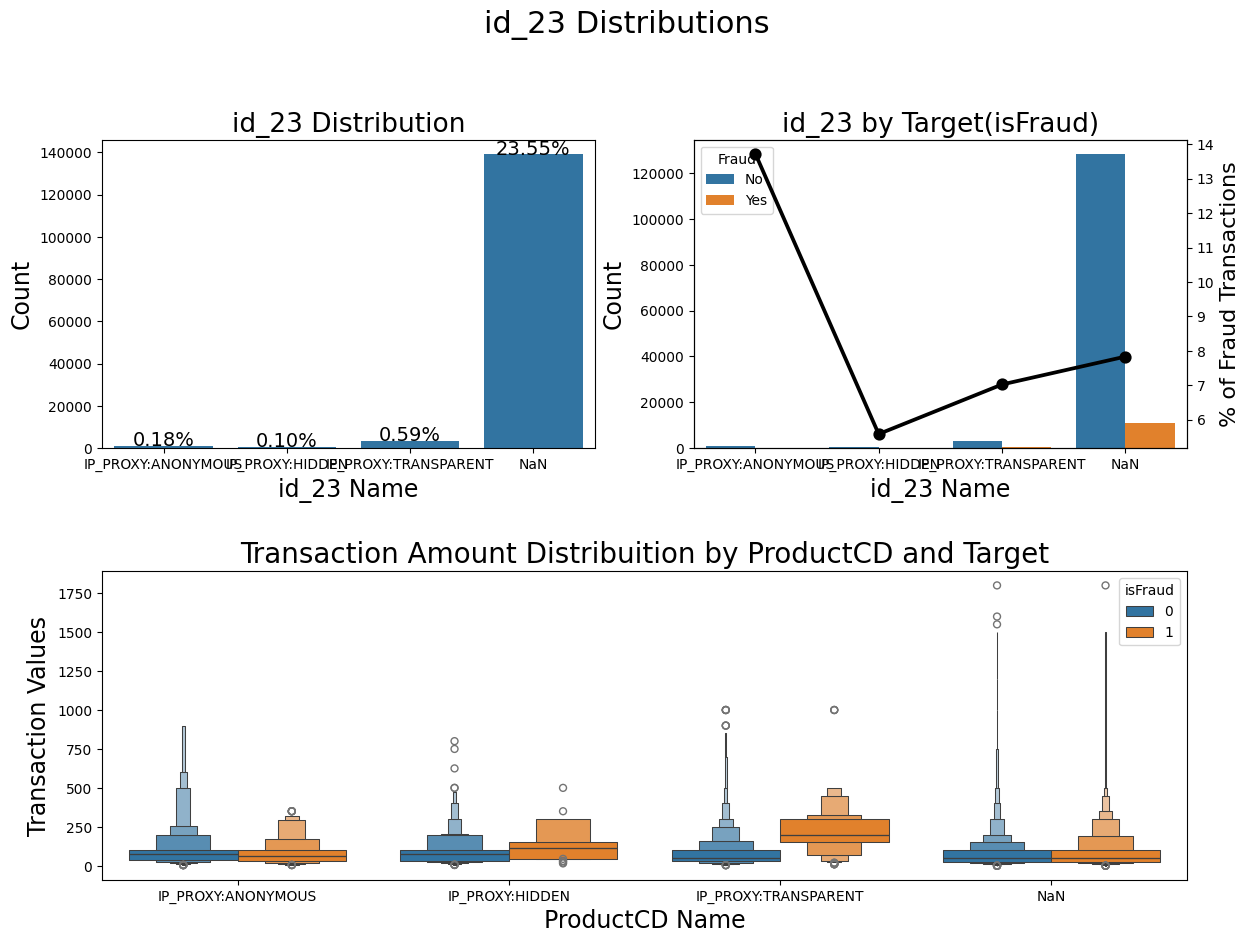

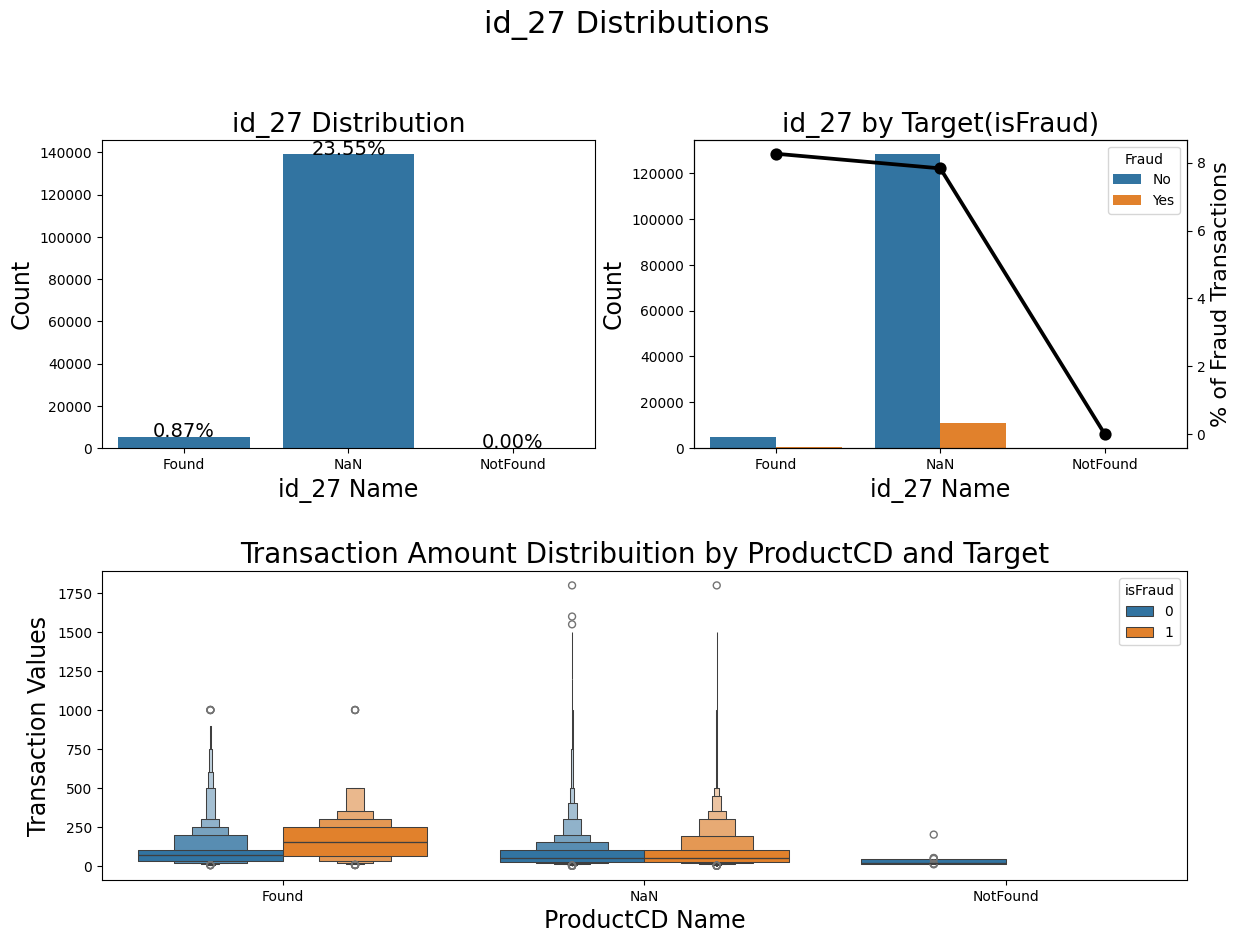

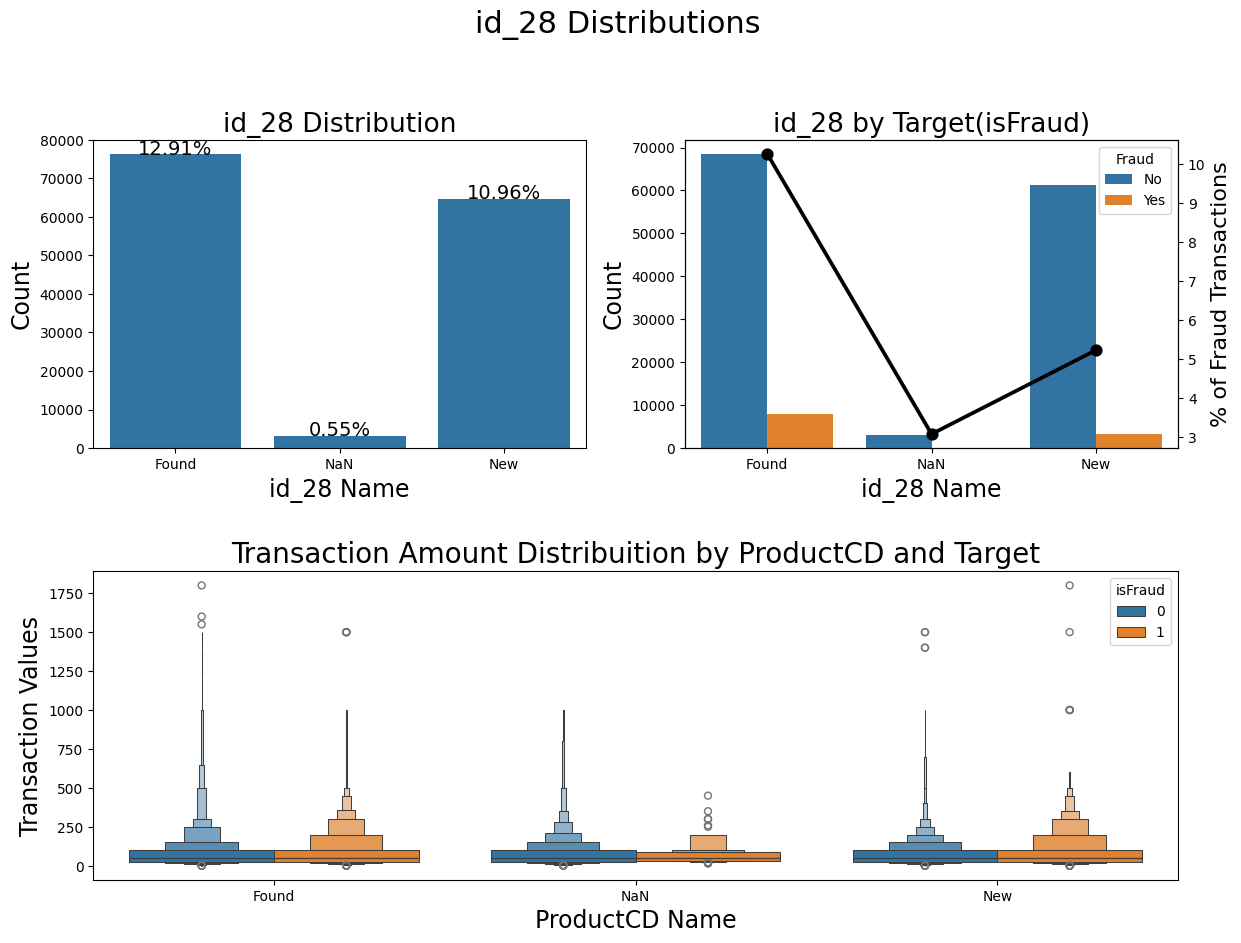

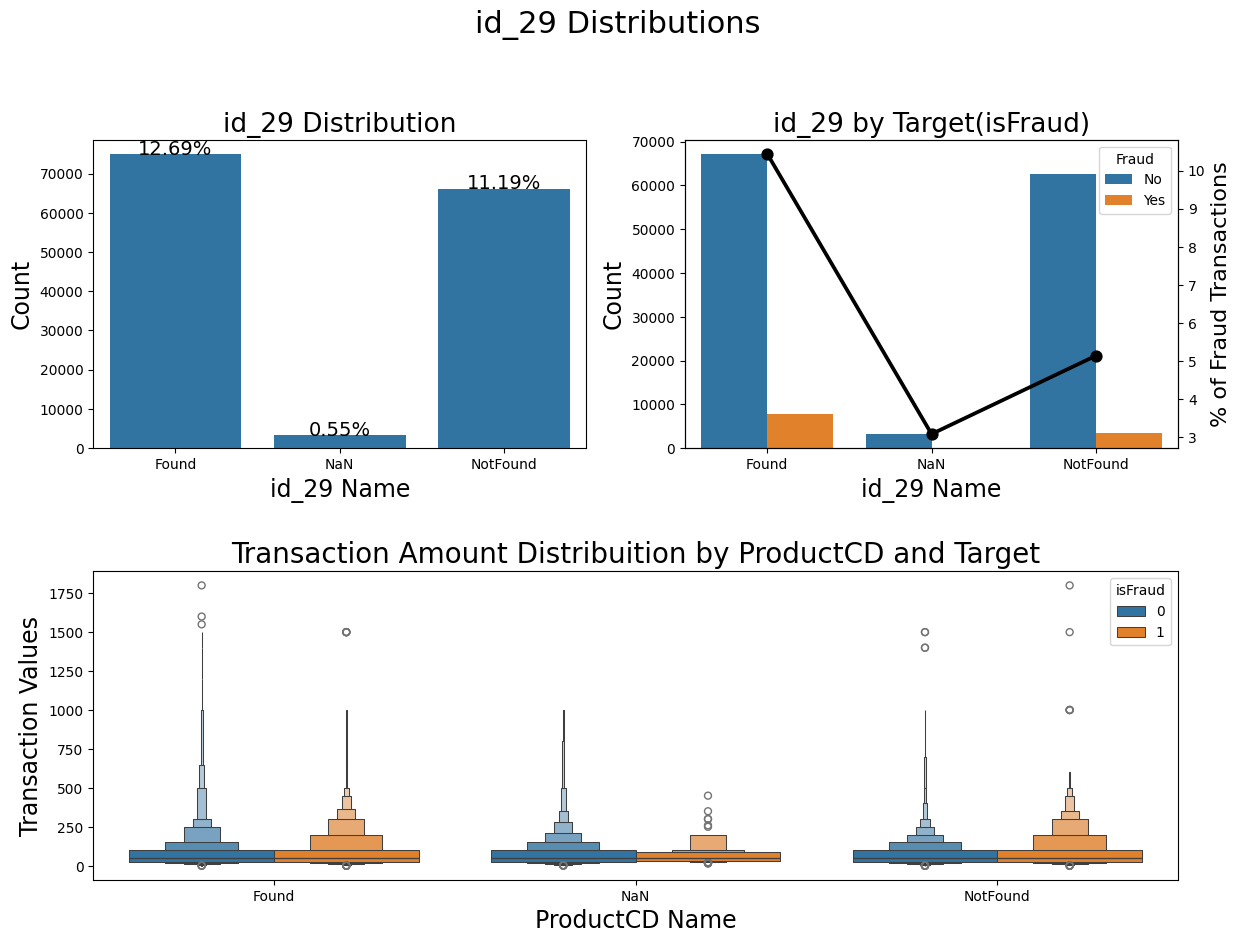

In [39]:
for col in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    train_merged[col] = train_merged[col].fillna('NaN')
    cat_feat_ploting(train_merged, col)

In [42]:
resumetable(train_merged[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (144233, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float64,0,1559,1.0,1.0,1.0,1.85
1,C2,float64,0,1182,1.0,1.0,4.0,2.36
2,C3,float64,0,27,0.0,0.0,0.0,0.14
3,C4,float64,0,1202,0.0,0.0,1.0,1.69
4,C5,float64,0,1,0.0,0.0,0.0,0.00
5,C6,float64,0,1194,1.0,1.0,1.0,1.50
6,C7,float64,0,1036,0.0,0.0,1.0,1.70
7,C8,float64,0,1236,1.0,1.0,1.0,1.95
8,C9,float64,0,1,0.0,0.0,0.0,0.00
9,C10,float64,0,1211,1.0,1.0,1.0,2.11


In [43]:
train_merged[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,144233.000000,144233.000000,144233.000000,144233.000000,144233.0,144233.000000,144233.000000,144233.000000,144233.0,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000
mean,27.793681,34.344533,0.023032,15.603558,0.0,15.583036,10.512830,19.395173,0.0,19.787483,20.359425,14.811687,20.517850,10.499685
std,249.745336,291.306999,0.303819,131.944756,0.0,132.514335,117.037122,181.039192,0.0,181.760988,176.778700,164.194903,165.660021,87.186134
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,1.000000,1.000000
75%,2.000000,2.000000,0.000000,1.000000,0.0,1.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,2.000000,1.000000
max,4685.000000,5691.000000,26.000000,2253.000000,0.0,2253.000000,2255.000000,3331.000000,0.0,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [44]:
#  C1 열에서 빈도가 400 이하인 값들을 "Others"로 대체합니다. 이는 데이터의 희소한 값을 하나의 범주로 묶어 데이터의 복잡성을 줄이는 데 유용할 수 있습니다.
train_merged.loc[train_merged.C1.isin(train_merged.C1\
                              .value_counts()[train_merged.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\964294691.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Others' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



C:\Users\USER\AppData\Local\Temp\ipykernel_20084\2954931372.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\2954931372.py:71: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\2954931372.py:75: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



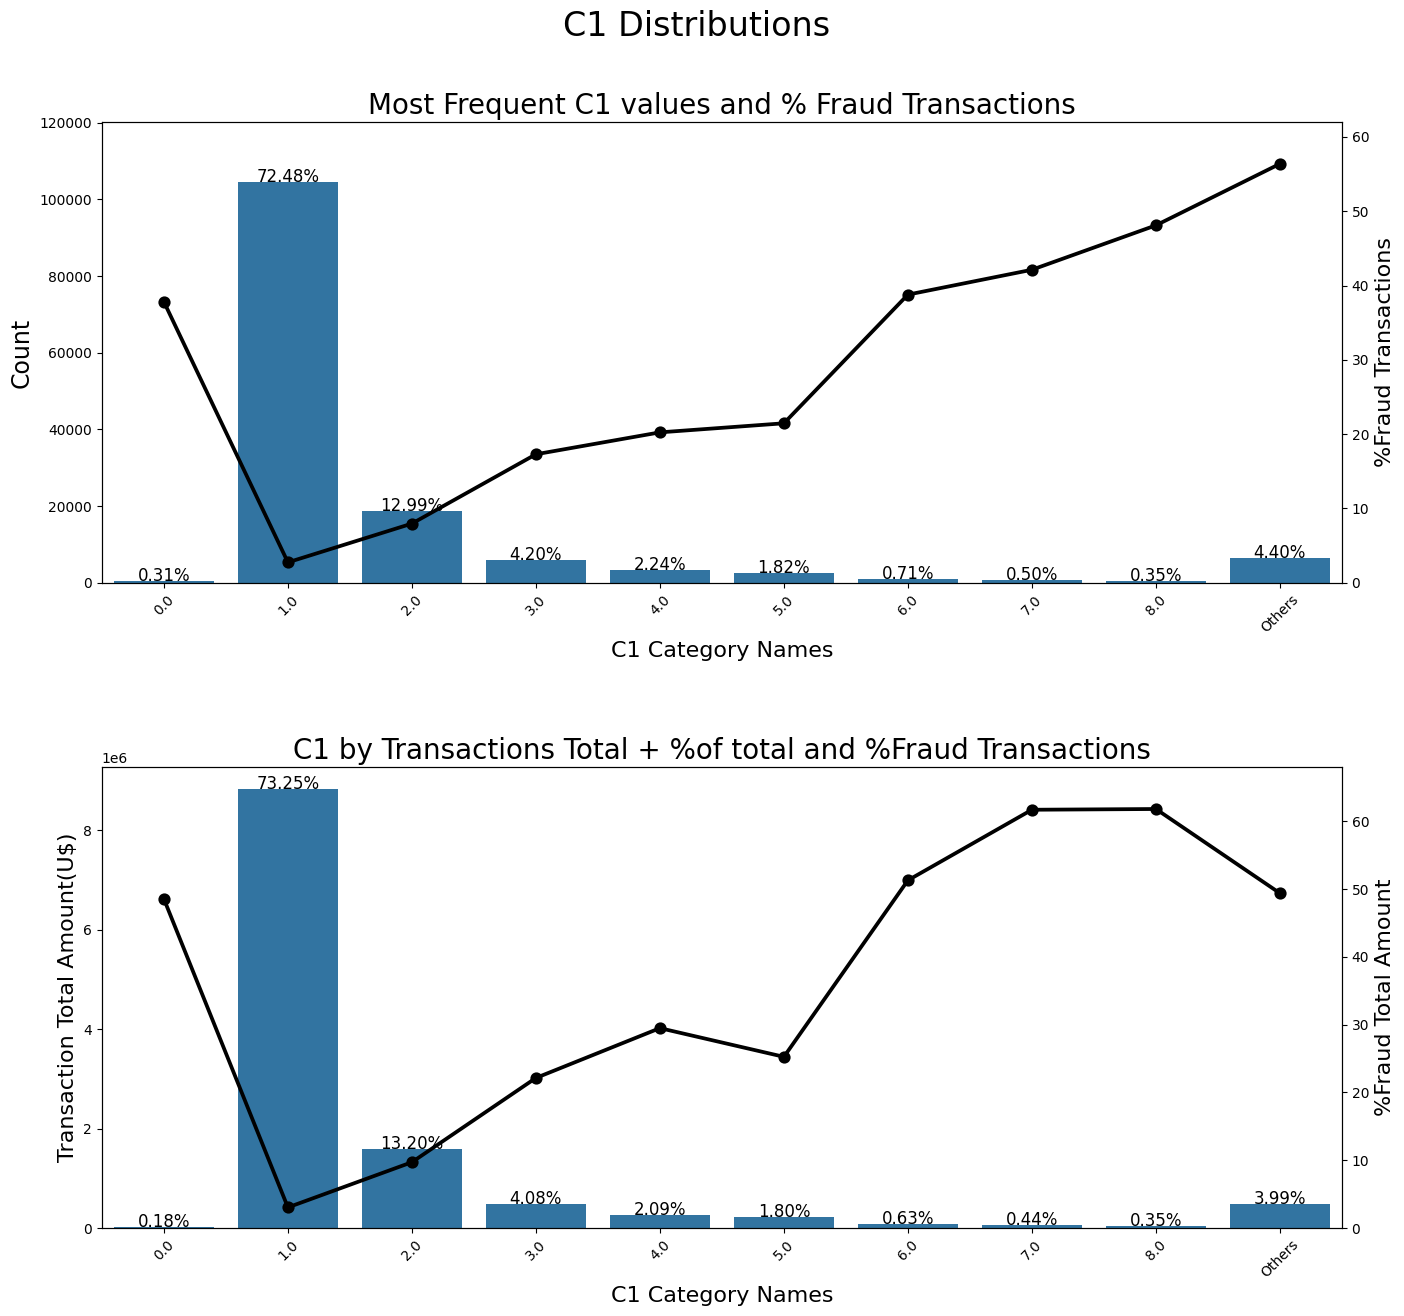

In [45]:
# 1 .주어진 열(col)의 값 분포와 사기 거래 비율을 계산하고 시각화합니다.
# 2. 거래 금액(TransactionAmt)에 대한 분포와 사기 거래 비율을 계산하고 시각화합니다.
ploting_cnt_amt(train_merged, 'C1')

In [46]:
#  C2 열에서 빈도가 350 이하인 값들을 "Others"로 대체합니다. 이는 데이터의 희소한 값을 하나의 범주로 묶어 데이터의 복잡성을 줄이는 데 유용할 수 있습니다.
train_merged.loc[train_merged.C2.isin(train_merged.C2\
                              .value_counts()[train_merged.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\1154917369.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Others' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



C:\Users\USER\AppData\Local\Temp\ipykernel_20084\2954931372.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\2954931372.py:71: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\USER\AppData\Local\Temp\ipykernel_20084\2954931372.py:75: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



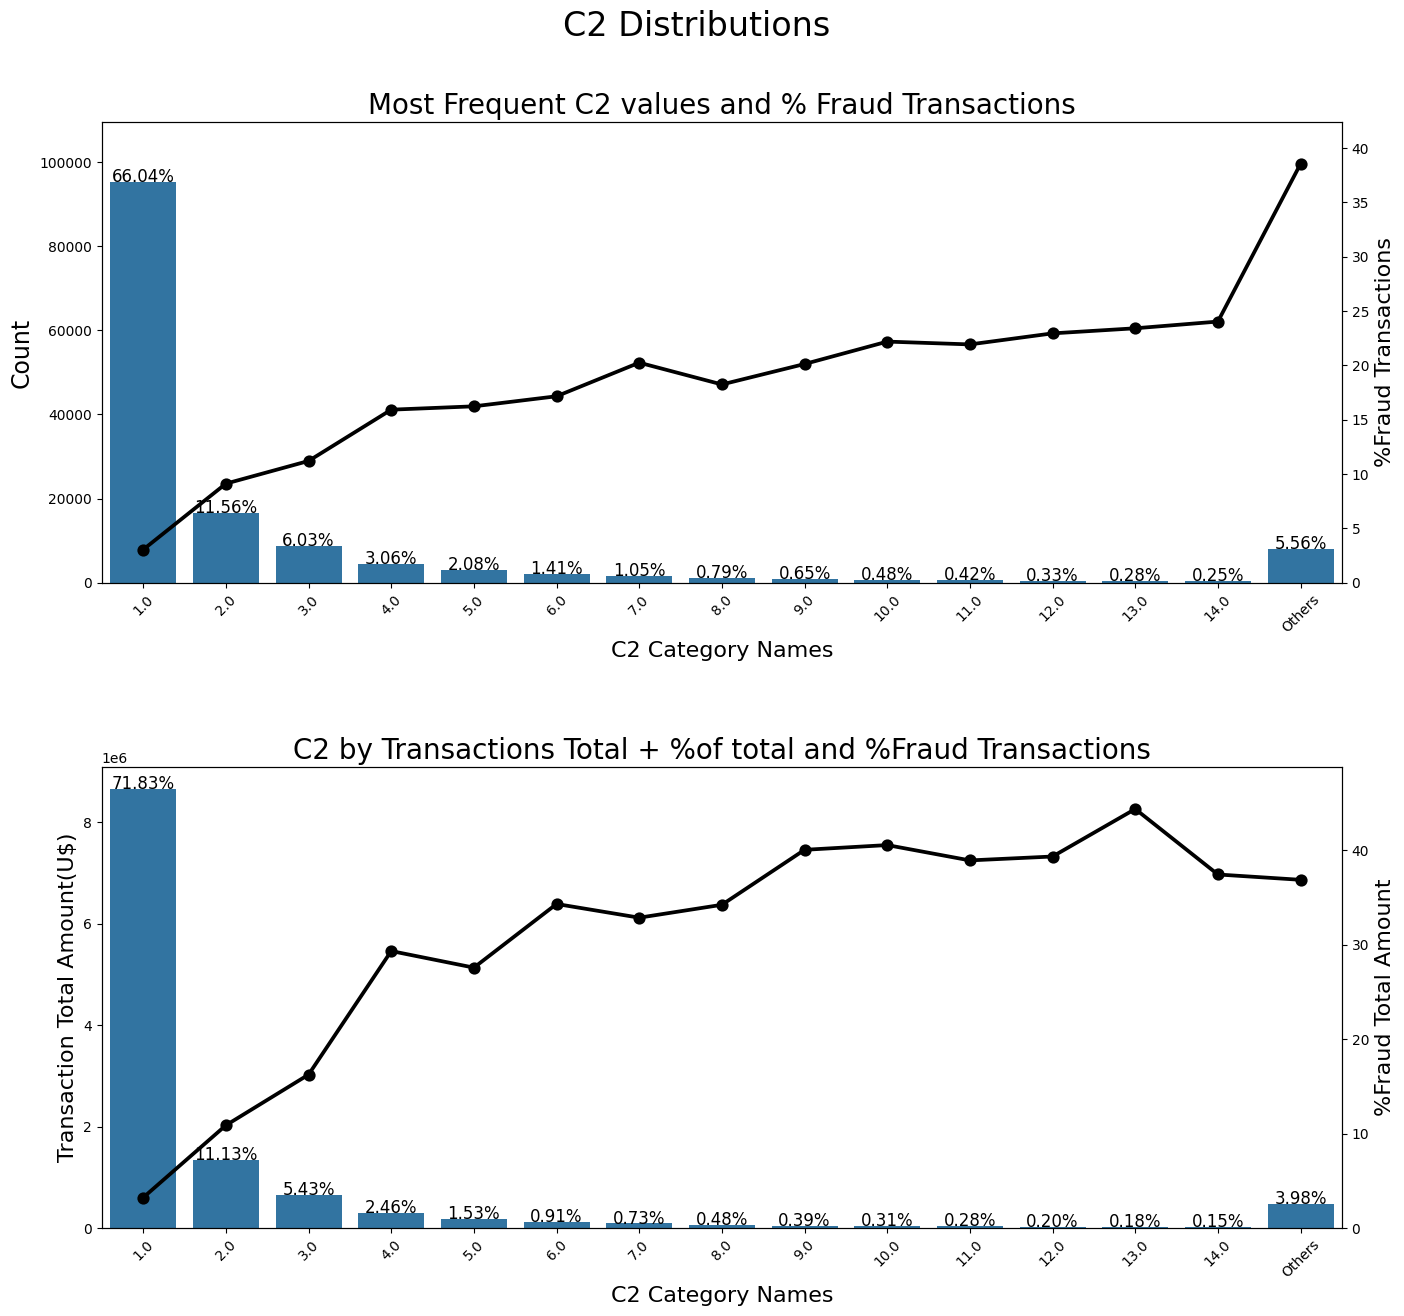

In [47]:
# 1 .주어진 열(col)의 값 분포와 사기 거래 비율을 계산하고 시각화합니다.
# 2. 거래 금액(TransactionAmt)에 대한 분포와 사기 거래 비율을 계산하고 시각화합니다.
ploting_cnt_amt(train_merged, 'C2')


상위 3개의 값은 1, 2, 3이며, 총 금액에서도 동일합니다. 우리는 사기 비율에서도 동일한 패턴을 봅니다.
나머지 카테고리들은 거래 수와 금액이 적지만, 사기 거래 비율이 상대적으로 높습니다.
그래서 상위 1,2,3 값 이외의 값들에서 사기 거래가 빈번하게 나타날 것이다 라는 가설을 세울 수 있습니다. 

첫번쨰 그래프의 왼쪽 Y축은 각 카테고리의 거래 수를 나타냅니다.
오른쪽 Y축(% Fraud Transactions): 해당 카테고리에서 발생한 사기 거래의 비율을 나타냅니다.
두번째 그래프의 왼쪽 Y축(Transaction Total Amount(US$)): 각 카테고리의 총 거래 금액을 나타냅니다.
오른쪽 Y축(%Fraud Total Amount): 해당 카테고리의 총 사기 거래 금액의 비율을 나타냅니다.